
## Behavioral_Clustering

Purpose:
--------
To segment customers into behavioral groups using K-Means clustering.

Business Questions:
-------------------
1. Can we discover behavioral patterns among our users?
2. Are there groups who use support heavily vs those who don’t?
3. Which segment is low-engagement but high-value (or vice versa)?
4. Which behaviors correlate with risk of churn?


In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

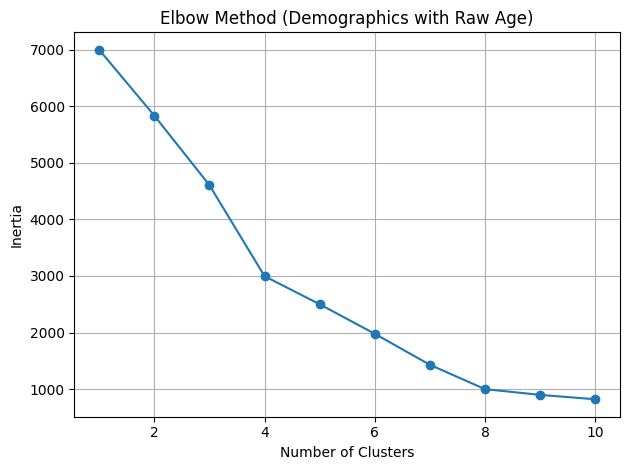

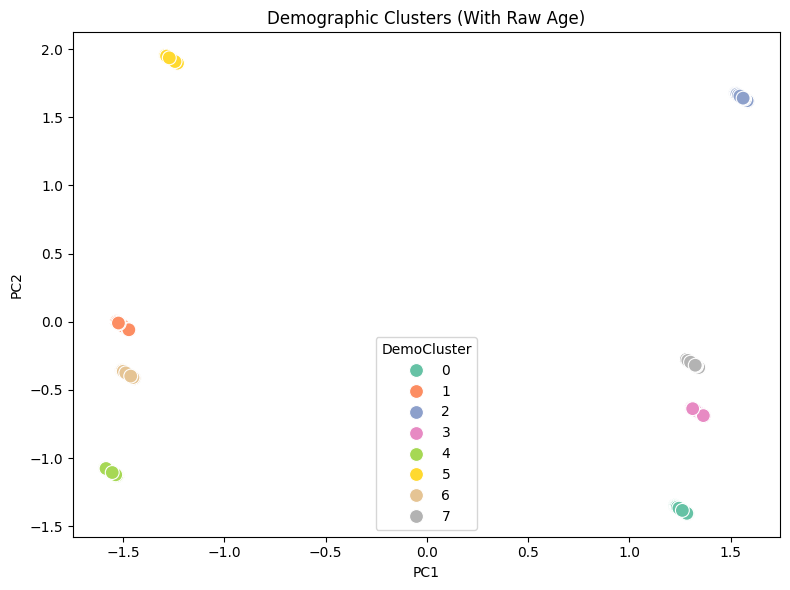

In [ ]:
# Load data
df = pd.read_csv("../data/raw/data_clean.csv")

# Subset demographic columns (with raw Age)
demo_df = df[['Age', 'Gender', 'MaritalStatus']].copy()

# One-hot encode categorical variables (keep all levels)
X_demo = pd.get_dummies(demo_df[['Age', 'Gender', 'MaritalStatus']], drop_first=False)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_demo)

# Elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title("Elbow Method (Demographics with Raw Age)")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.tight_layout()
plt.show()

# Apply KMeans (k=8 as per your use case)
k = 8
kmeans = KMeans(n_clusters=k, random_state=42)
demo_df['DemoCluster'] = kmeans.fit_predict(X_scaled)

# Optional: PCA for plotting
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)
demo_df['PC1'] = components[:, 0]
demo_df['PC2'] = components[:, 1]

# Visualize clusters via PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=demo_df, x='PC1', y='PC2', hue='DemoCluster', palette='Set2', s=100)
plt.title("Demographic Clusters (With Raw Age)")
plt.tight_layout()
plt.show()

# Merge back

# Add CustomerID if not already in demo_df
demo_df['CustomerID'] = df['CustomerID']

# Merge into main df
df = df.merge(demo_df[['CustomerID', 'DemoCluster']], on='CustomerID', how='left')



C:\Users\ARKA\AppData\Local\Temp\ipykernel_26672\2079750965.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='DemoCluster', y='Age', palette='Set2')


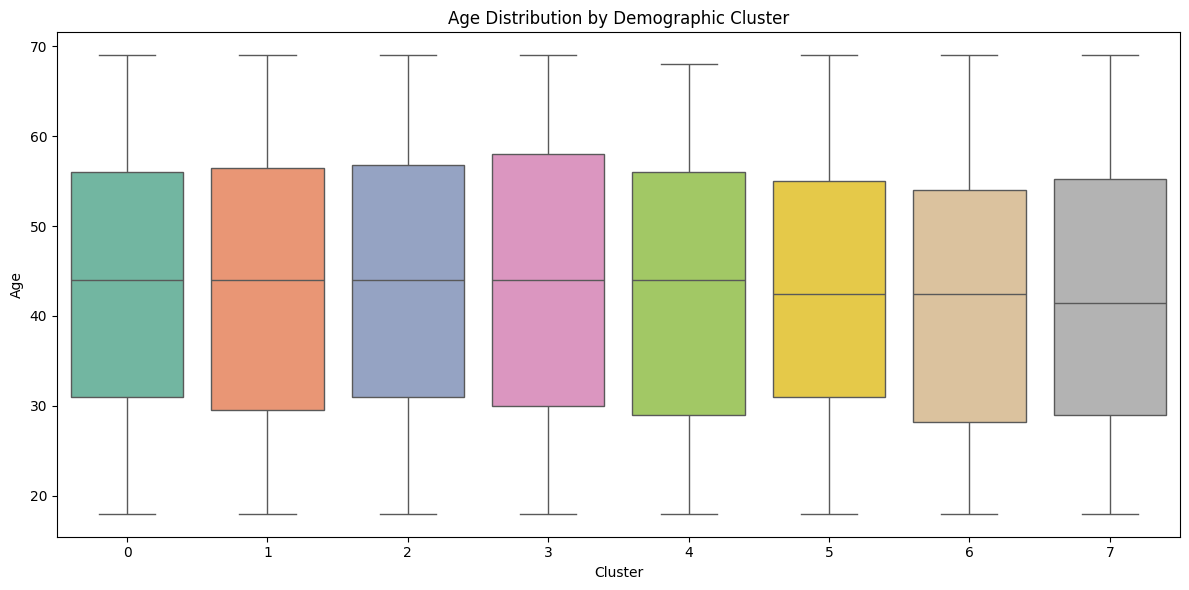

In [35]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='DemoCluster', y='Age', palette='Set2')
plt.title("Age Distribution by Demographic Cluster")
plt.xlabel("Cluster")
plt.ylabel("Age")
plt.tight_layout()
plt.show()

In [36]:
# Optional: Create age bins for better grouping
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 30, 40, 50, 60, 100], labels=['<30', '30-40', '40-50', '50-60', '60+'])


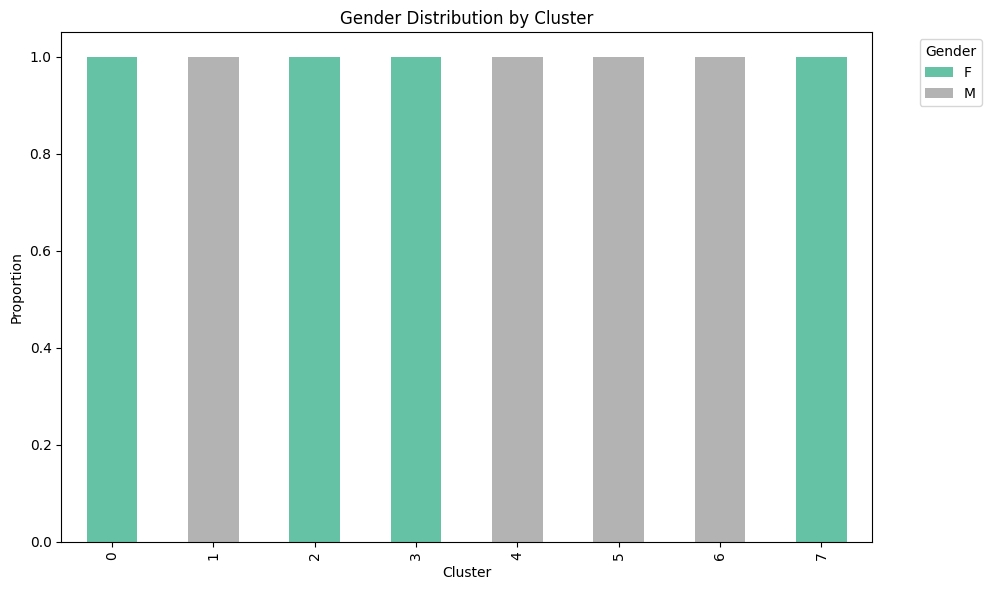

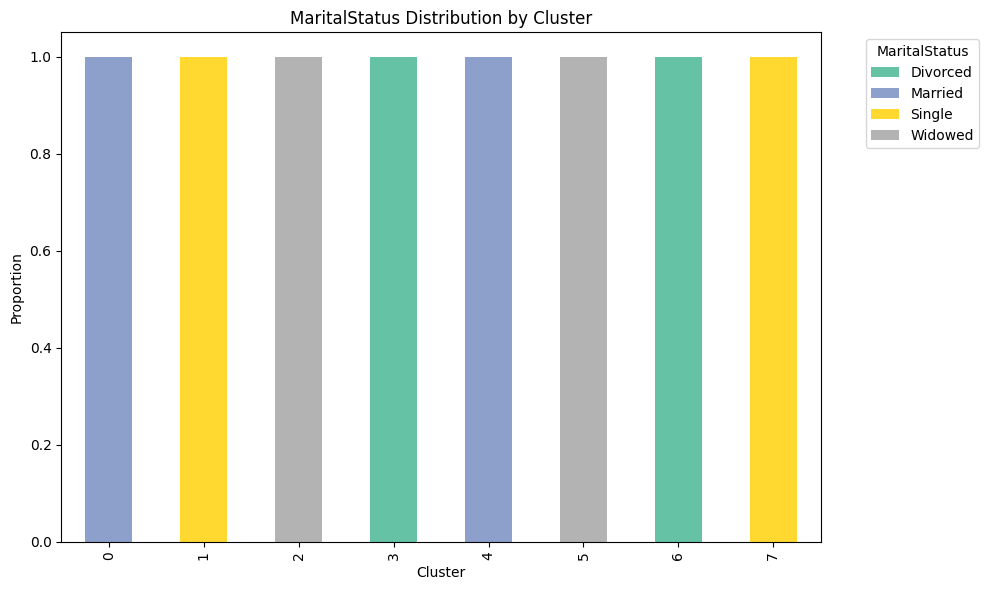

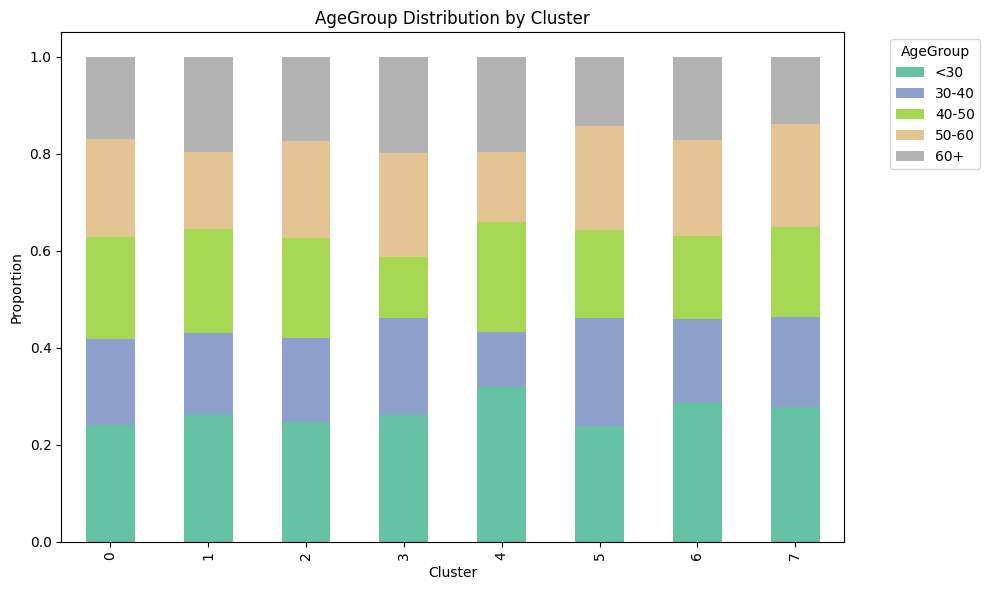

In [37]:
def plot_stacked_bar(data, feature, cluster_col='DemoCluster', normalize=True):
    if cluster_col not in data.columns or feature not in data.columns:
        raise ValueError(f"{cluster_col} or {feature} not in DataFrame")

    crosstab = pd.crosstab(data[cluster_col], data[feature], normalize='index' if normalize else False)
    crosstab.plot(kind='bar', stacked=True, colormap='Set2', figsize=(10, 6))

    plt.title(f'{feature} Distribution by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Proportion' if normalize else 'Count')
    plt.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Run these after verifying column presence
plot_stacked_bar(df, 'Gender')
plot_stacked_bar(df, 'MaritalStatus')
plot_stacked_bar(df, 'AgeGroup')  # only if you created it earlier



C:\Users\ARKA\AppData\Local\Temp\ipykernel_26672\4036942793.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cluster_data, x='Gender', ax=axes[idx, 0], palette='pastel', order=cluster_data['Gender'].value_counts().index)
C:\Users\ARKA\AppData\Local\Temp\ipykernel_26672\4036942793.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cluster_data, x='MaritalStatus', ax=axes[idx, 1], palette='muted', order=cluster_data['MaritalStatus'].value_counts().index)
C:\Users\ARKA\AppData\Local\Temp\ipykernel_26672\4036942793.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=

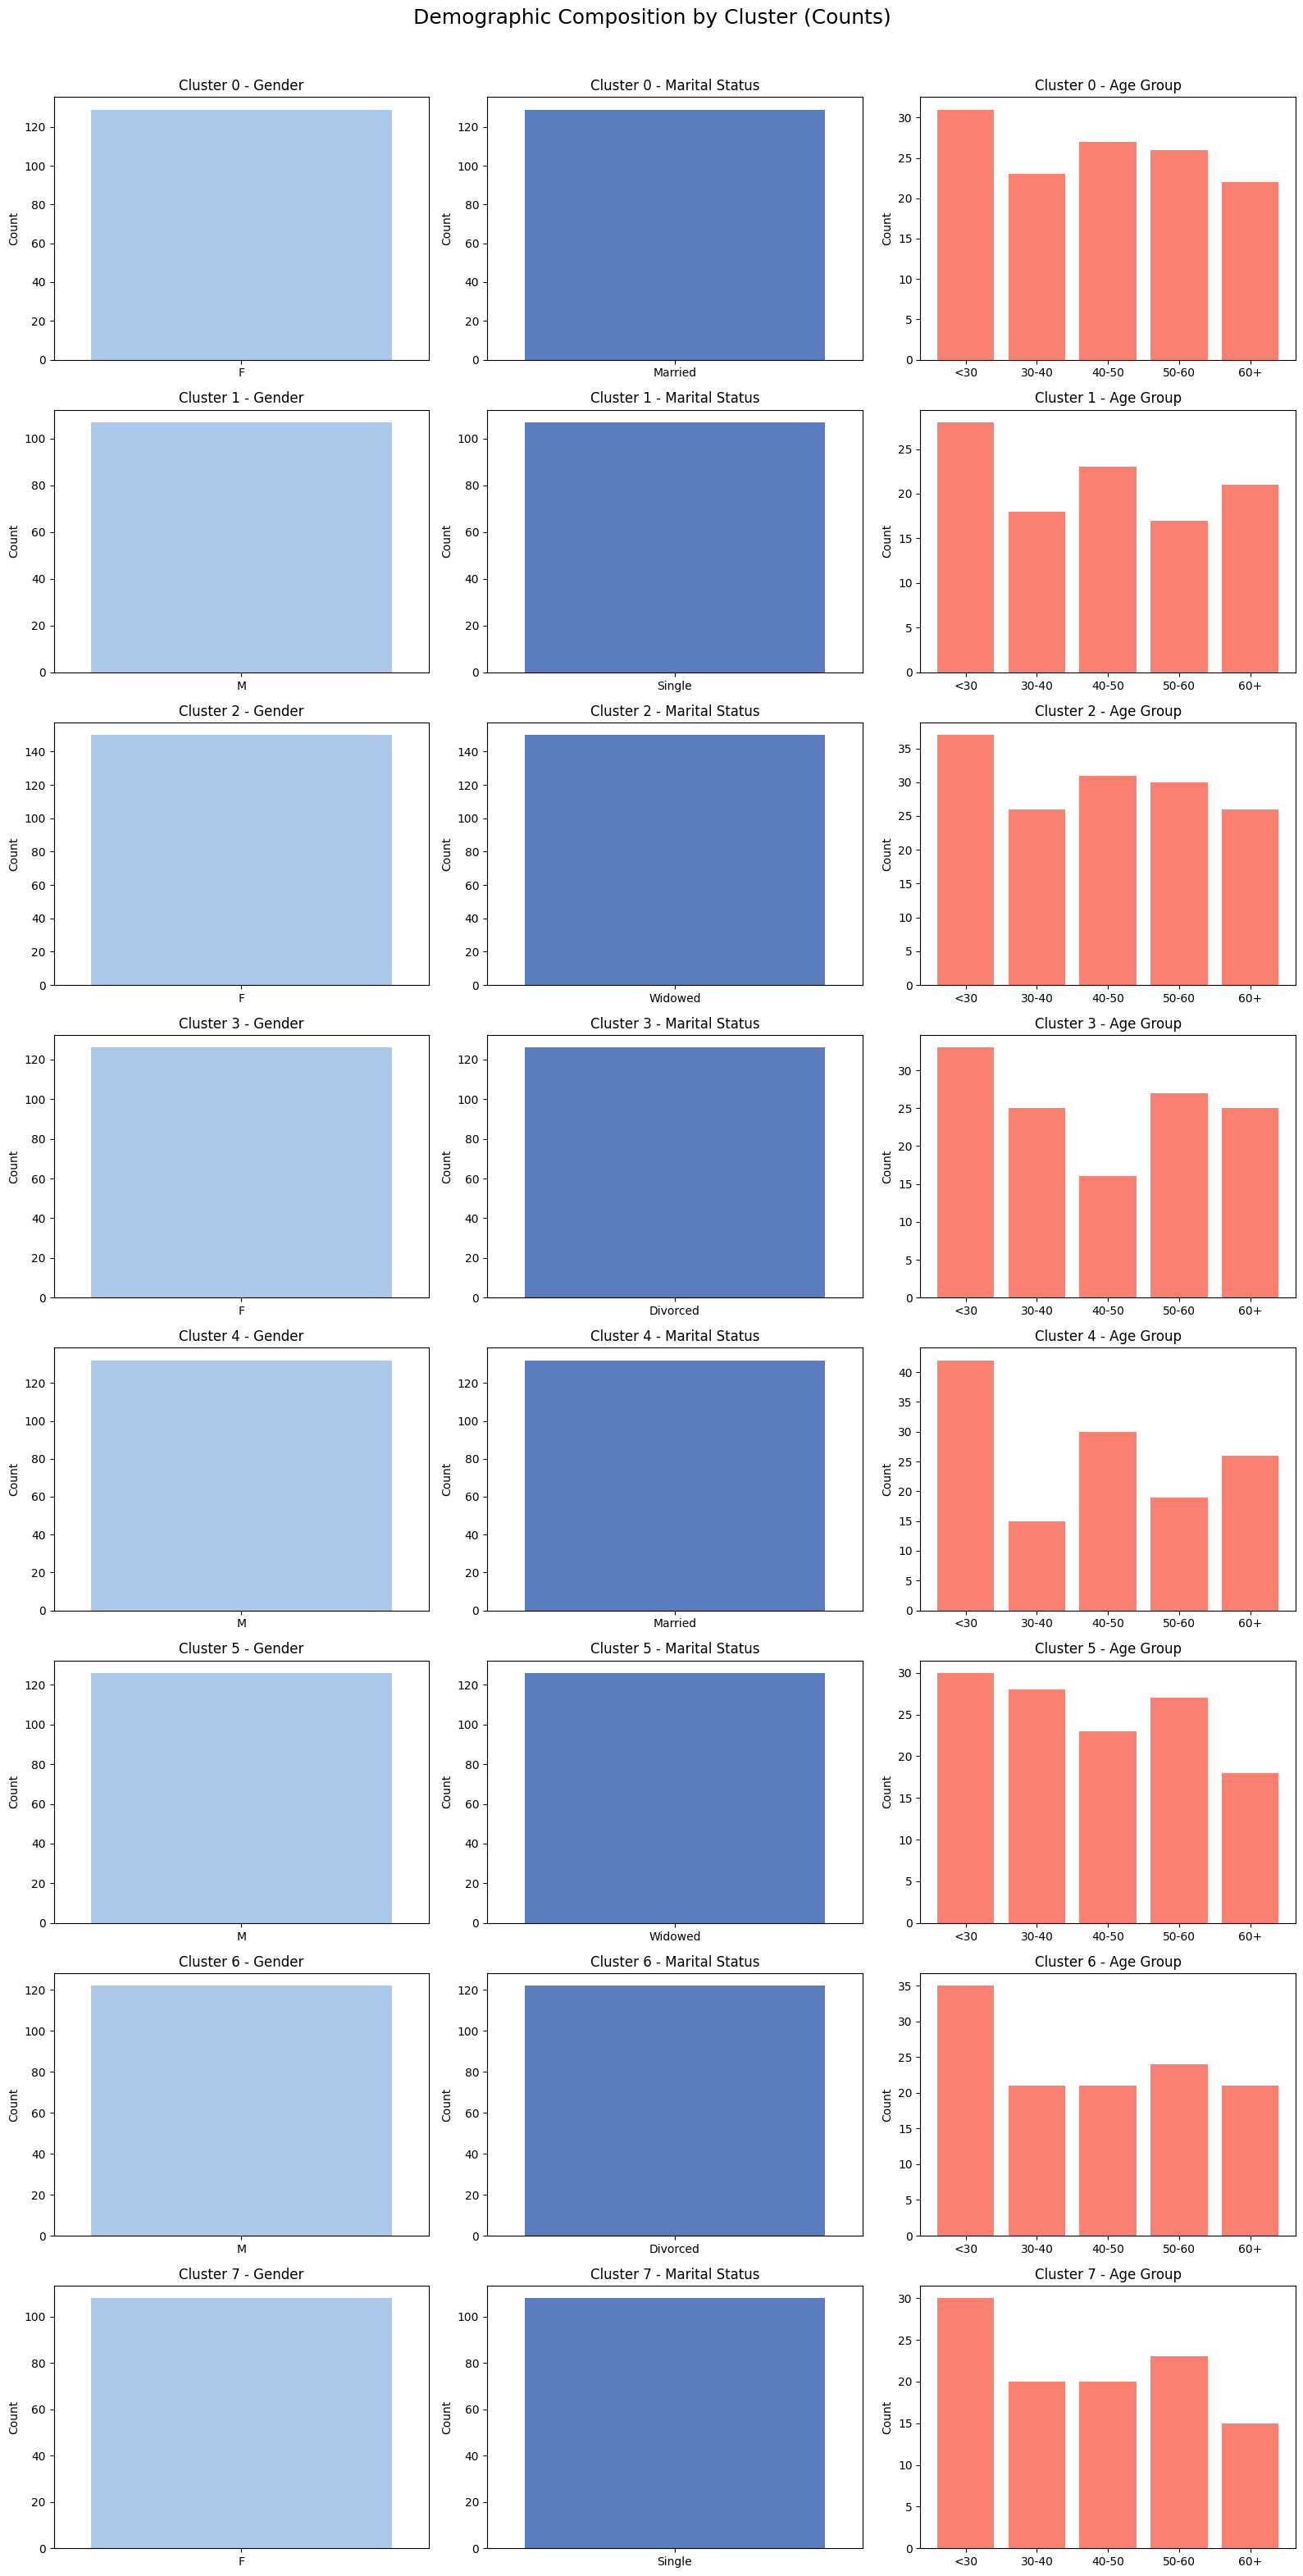

In [ ]:
# Ensure AgeGroup exists
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 30, 40, 50, 60, 100],
                        labels=['<30', '30-40', '40-50', '50-60', '60+'])

# Unique clusters
clusters = sorted(df['DemoCluster'].unique())

# Setup plot grid
fig, axes = plt.subplots(len(clusters), 3, figsize=(16, 4 * len(clusters)))
fig.suptitle("Demographic Composition by Cluster (Counts)", fontsize=18)

for idx, cluster in enumerate(clusters):
    cluster_data = df[df['DemoCluster'] == cluster]

    # Gender count plot
    sns.countplot(data=cluster_data, x='Gender', ax=axes[idx, 0], palette='pastel', order=cluster_data['Gender'].value_counts().index)
    axes[idx, 0].set_title(f"Cluster {cluster} - Gender")

    # Marital status count plot
    sns.countplot(data=cluster_data, x='MaritalStatus', ax=axes[idx, 1], palette='muted', order=cluster_data['MaritalStatus'].value_counts().index)
    axes[idx, 1].set_title(f"Cluster {cluster} - Marital Status")

    # Age group distribution (still as proportion for consistency)
    age_dist = cluster_data['AgeGroup'].value_counts(normalize=False).sort_index()
    axes[idx, 2].bar(age_dist.index.astype(str), age_dist.values, color='salmon')
    axes[idx, 2].set_title(f"Cluster {cluster} - Age Group")

# Label tweaks
for ax_row in axes:
    for ax in ax_row:
        ax.set_ylabel("Count")
        ax.set_xlabel("")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [ ]:


# Ensure AgeGroup exists for easier interpretation
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 30, 40, 50, 60, 100],
                        labels=['<30', '30-40', '40-50', '50-60', '60+'])

# Function to generate profile summary for each cluster
def summarize_cluster_profiles(df, cluster_col='DemoCluster'):
    profiles = []
    clusters = sorted(df[cluster_col].unique())

    for c in clusters:
        sub = df[df[cluster_col] == c]
        size = len(sub)
        age_mean = sub['Age'].mean().round(1)
        top_age_group = sub['AgeGroup'].mode()[0] if not sub['AgeGroup'].mode().empty else 'N/A'
        top_gender = sub['Gender'].mode()[0] if not sub['Gender'].mode().empty else 'N/A'
        top_marital = sub['MaritalStatus'].mode()[0] if not sub['MaritalStatus'].mode().empty else 'N/A'

        profiles.append({
            'Cluster': c,
            'Count': size,
            'AvgAge': age_mean,
            'TopAgeGroup': top_age_group,
            'TopGender': top_gender,
            'TopMaritalStatus': top_marital
        })

    return pd.DataFrame(profiles)

# Run it
demo_cluster_profiles = summarize_cluster_profiles(df)





,Cluster,Count,AvgAge,TopAgeGroup,TopGender,TopMaritalStatus
0,0,129,44.0,<30,F,Married
1,1,107,43.6,<30,M,Single
2,2,150,43.5,<30,F,Widowed
3,3,126,43.9,<30,F,Divorced
4,4,132,43.0,<30,M,Married
5,5,126,43.0,<30,M,Widowed
6,6,122,42.7,<30,M,Divorced
7,7,108,42.3,<30,F,Single


In [49]:
# Display the summary
demo_cluster_profiles.to_csv("democluster.csv", index=False)

In [ ]:
df=df.drop(columns=['DemoSegment'], axis=1)

)

KeyError: "['DemoSegment'] not found in axis"

In [55]:
df.to_csv("Maindf_demo.csv", index=False)

Business Questions & Insights from Cluster Data

1. What are the dominant demographic profiles across our customer base?

All clusters have a similar average age (~43), but the top age group in every cluster is "<30" — this likely means there’s a large concentration of younger individuals, even though the average is skewed higher by older members.

Gender is evenly distributed across clusters, with a slight female dominance in 4 out of 8 clusters.

Marital status varies:

Married and Widowed appear frequently — these may be linked to more stable financial behaviors.

Single and Divorced are also present, especially in younger male clusters.

Business Implication:
You serve a diverse demographic, but the under-30 age group is strongly represented across all segments.

Tailoring products or communication based on marital status and gender may improve relevance.

2. Are there customer segments we should target differently based on demographics?
Insights:
Clusters 1, 4, 5, 6: All are male-dominant, with different marital statuses.

Clusters 0, 2, 3, 7: Female-dominant, showing a variety of relationship statuses.

Some interesting patterns:

Cluster 2: Female & Widowed – may need special financial planning tools or personalized support.

Cluster 1: Young Single Males – possibly less engaged; may respond to tech-focused or investment products.

Business Recommendations:
Create persona-based campaigns:

Young single males → Target with investment or budgeting tools.

Widowed females → Offer support services, savings plans.

Married segments → Family-centric or home-finance packages.

3. How can we align product offerings with different clusters?
Insights:
Each cluster shows distinct combinations of age, gender, and marital status, suggesting different financial needs.

Segment-specific ideas:
Cluster	Profile Summary	Product Opportunity
0	F, Married, AvgAge 44	Joint accounts, family savings plans

1	M, Single, AvgAge 43.6	High-risk investments, gamified apps

2	F, Widowed	Retirement planning, advisory support

3	F, Divorced	Personal loans, independent banking

4	M, Married	Mortgages, insurance products

5	M, Widowed	Pension plans, asset management

6	M, Divorced	Mid-life financial restructuring

7	F, Single	Career-related services, digital tools

4. Can we use this to personalize marketing or UX?
 Yes:
Personalized UX: Show relevant offers on dashboards based on cluster membership.

Targeted Marketing:

Email content and tone adapted to gender and life stage.

Use marital status to adjust recommendations (e.g., “Family budgeting” vs. “Solo travel cards”).

 Summary
You have clear demographic clusters that reflect different life stages and financial needs. By aligning your product offerings, communication, and UX to these clusters, you can:

Improve engagement

Reduce churn

Increase conversion and loyalty